# 0️⃣ Projektbeschreibung

## 📊 Machine Learning Portfolio Project – Out-of-School Analysis

### 🎓 Global Out-of-School Children Analysis (1970–2023)

Dieses Projekt analysiert den World Bank Indikator **SE.PRM.UNER.ZS**, der den Anteil von Grundschulkindern zeigt, die **nicht eingeschult** sind (Out of School Children – OOSC).

---

### 🎯 Projektziele:
1. Entwicklung einer End-to-End Data Analysis Pipeline
2. Anwendung von Data Wrangling, EDA und ML-Modellierung
3. Erstellung eines GitHub-tauglichen Portfolio-Projekts für Bewerbungen im Data Science / ML-Bereich

---

### 🔗 Datenquelle:
- World Bank World Development Indicators (WDI)


# 1️⃣ Importiere Libraries

Wir starten mit dem Import aller benötigten Libraries für Datenanalyse, Visualisierung und Machine Learning.


In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Notebook-Style
plt.style.use("seaborn-v0_8")


# 2️⃣ Lade OOSC-Daten

Wir lesen die World Bank CSV-Datei ein.  
**Hinweis:** Die Datei enthält **4 Kopfzeilen mit Metadaten**, die wir mit `skiprows=4` überspringen.


In [15]:
# Dateipfad
csv_file = "oosc_wdi.csv"

# Laden
df = pd.read_csv(csv_file, skiprows=4)
print("Shape:", df.shape)
df.head()


Shape: (266, 70)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Children out of school (% of primary school age),SE.PRM.UNER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Children out of school (% of primary school age),SE.PRM.UNER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Children out of school (% of primary school age),SE.PRM.UNER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Children out of school (% of primary school age),SE.PRM.UNER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Children out of school (% of primary school age),SE.PRM.UNER.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3️⃣ Transformation in Long-Format

Die World Bank Daten sind im Wide-Format gespeichert (jedes Jahr als eigene Spalte).  
Wir transformieren sie mit `melt()` ins Long-Format:

- Jede Zeile = Country-Year Kombination  
- Spalten: Country Name, Year, OOSC_rate


In [16]:
# Identifiziere Jahres-Spalten
year_cols = [c for c in df.columns if c.isdigit()]

# Melt (Wide ➔ Long)
df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="OOSC_rate"
)

# Typumwandlung
df_long["Year"] = df_long["Year"].astype(int)
df_long["OOSC_rate"] = pd.to_numeric(df_long["OOSC_rate"], errors="coerce")

# Entferne fehlende Werte
df_long = df_long.dropna(subset=["OOSC_rate"])

print("Shape nach Transformation:", df_long.shape)
df_long.head()


Shape nach Transformation: (5107, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,OOSC_rate
2669,Argentina,ARG,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,4.919240
2680,Bangladesh,BGD,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,50.503681
2689,Brazil,BRA,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,29.643890
2693,Botswana,BWA,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,50.468609
2708,Costa Rica,CRI,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,13.047480


# 4️⃣ Data Quality Check

Wir prüfen:
- Statistische Kennzahlen der OOSC-Rate
- Negative Werte (unmöglich)
- Werte über 100 % (Prozentbegrenzung)


In [19]:
print("Summary Statistics:\n", df_long["OOSC_rate"].describe())

# Negative Werte?
neg = df_long[df_long["OOSC_rate"] < 0]
print("\nNegative Werte:", neg.shape[0])

# Werte > 100%?
over = df_long[df_long["OOSC_rate"] > 100]
print("Werte über 100%:", over.shape[0])


Summary Statistics:
 count    5107.000000
mean       12.419547
std        16.591574
min         0.000000
25%         1.570000
50%         5.417330
75%        15.370537
max        89.862869
Name: OOSC_rate, dtype: float64

Negative Werte: 0
Werte über 100%: 0


# 5️⃣ Globale Trends analysieren

Wir plotten den weltweiten Durchschnitt der OOSC-Rate über die Zeit, um langfristige Trends zu erkennen.


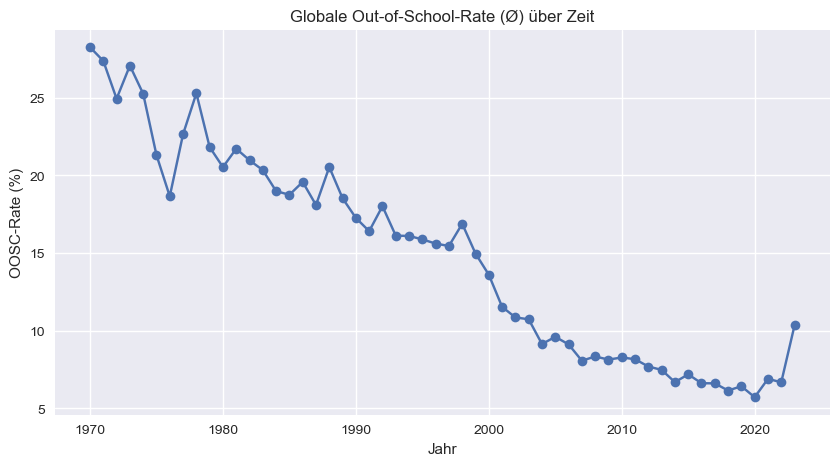

In [20]:
# Durchschnittliche OOSC-Rate pro Jahr
global_trend = df_long.groupby("Year")["OOSC_rate"].mean()

plt.figure(figsize=(10,5))
plt.plot(global_trend.index, global_trend.values, marker="o")
plt.title("Globale Out-of-School-Rate (Ø) über Zeit")
plt.xlabel("Jahr")
plt.ylabel("OOSC-Rate (%)")
plt.grid(True)
plt.show()


# 6️⃣ Verteilung der OOSC-Rate

Wir visualisieren die Verteilung der OOSC-Rate über alle Länder und Jahre hinweg.


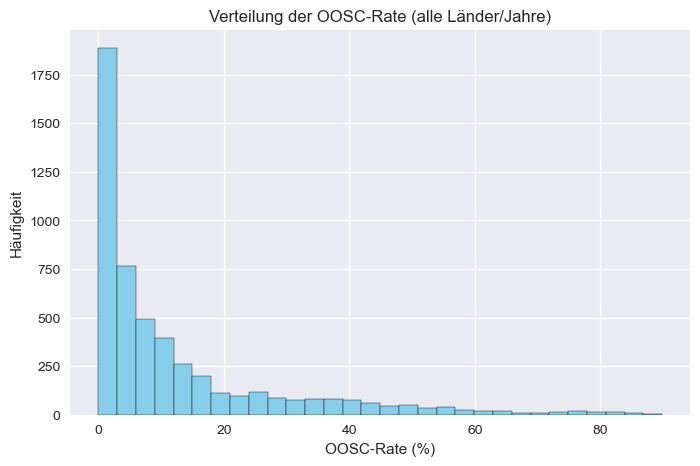

In [21]:
plt.figure(figsize=(8,5))
plt.hist(df_long["OOSC_rate"], bins=30, color="skyblue", edgecolor="black")
plt.title("Verteilung der OOSC-Rate (alle Länder/Jahre)")
plt.xlabel("OOSC-Rate (%)")
plt.ylabel("Häufigkeit")
plt.show()


# 7️⃣ Top-10 Länder im letzten Jahr

Wir identifizieren die Länder mit den höchsten OOSC-Raten im zuletzt verfügbaren Jahr.


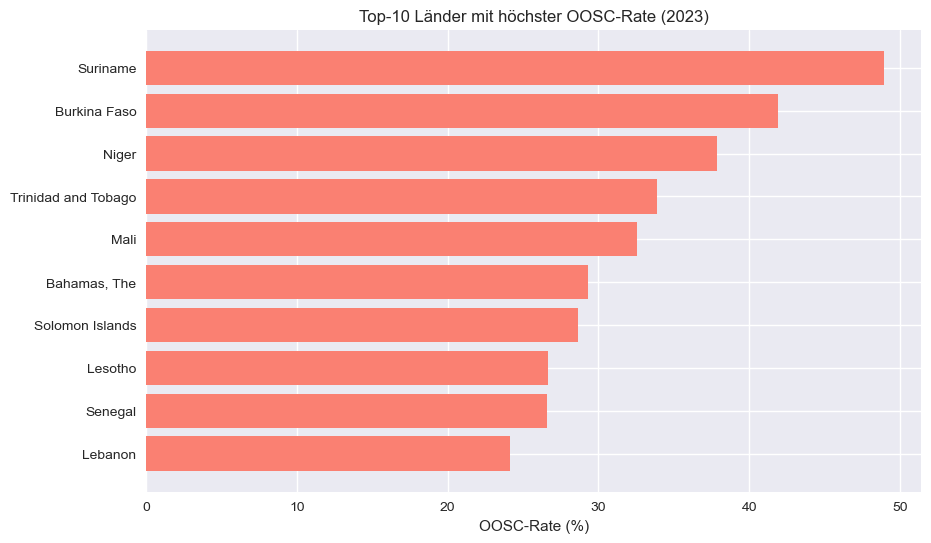

In [22]:
latest_year = df_long["Year"].max()
top10 = df_long[df_long["Year"] == latest_year].sort_values("OOSC_rate", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10["Country Name"], top10["OOSC_rate"], color="salmon")
plt.title(f"Top-10 Länder mit höchster OOSC-Rate ({latest_year})")
plt.xlabel("OOSC-Rate (%)")
plt.gca().invert_yaxis()
plt.show()


# 8️⃣ GDP-Dummy-Daten generieren

Da der API-Download nicht funktionierte, generieren wir hier simulierte GDP-Daten, um den ML-Prozess üben zu können.


In [23]:
# GDP Dummy-Daten simulieren
gdp_mock = df_long[["Country Name", "Country Code", "Year"]].drop_duplicates().copy()

np.random.seed(42)
gdp_mock["GDP_per_capita"] = np.random.normal(loc=5000, scale=2000, size=len(gdp_mock))
gdp_mock["GDP_per_capita"] = gdp_mock["GDP_per_capita"].clip(lower=500, upper=50000)

gdp_mock.head()


,Country Name,Country Code,Year,GDP_per_capita
2669,Argentina,ARG,1970,5993.428306
2680,Bangladesh,BGD,1970,4723.471398
2689,Brazil,BRA,1970,6295.377076
2693,Botswana,BWA,1970,8046.059713
2708,Costa Rica,CRI,1970,4531.693251


# 9️⃣ Merge OOSC + GDP

Wir verbinden die OOSC-Daten mit den GDP-Daten, um ein vollständiges DataFrame für das ML-Modell zu erhalten.


In [24]:
df_ml = pd.merge(df_long, gdp_mock, on=["Country Name", "Country Code", "Year"], how="inner")
print("Shape nach Merge:", df_ml.shape)
df_ml.head()


Shape nach Merge: (5107, 7)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,OOSC_rate,GDP_per_capita
0,Argentina,ARG,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,4.919240,5993.428306
1,Bangladesh,BGD,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,50.503681,4723.471398
2,Brazil,BRA,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,29.643890,6295.377076
3,Botswana,BWA,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,50.468609,8046.059713
4,Costa Rica,CRI,Children out of school (% of primary school age),SE.PRM.UNER.ZS,1970,13.047480,4531.693251


# 🔟 Multivariate Regression: OOSC_rate ~ GDP + Year

Wir modellieren die OOSC-Rate als Funktion von GDP per capita und Jahr.


In [25]:
# Features & Target
X = df_ml[["GDP_per_capita", "Year"]]
y = df_ml["OOSC_rate"]

# Modell trainieren
model = LinearRegression()
model.fit(X, y)

# Ergebnisse
print("Intercept:", model.intercept_)
print("Coefficients:")
for feat, coef in zip(X.columns, model.coef_):
    print(f"  {feat}: {coef:.4f}")


Intercept: 818.5723740250277
Coefficients:
  GDP_per_capita: -0.0001
  Year: -0.4025


# ✅ Projektfazit

Dieses Projekt demonstrierte eine vollständige ML-Workflow-Pipeline:

1. **Data Acquisition & Wrangling**
2. **Explorative Analyse & Visualisierung**
3. **Multivariate Regression**